In [3]:
# =====================
# 📌 1. Import Libraries
# =====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Supervised models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Mall Customers dataset (Kaggle version)
df = pd.read_csv("Mall_Customers.csv")
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


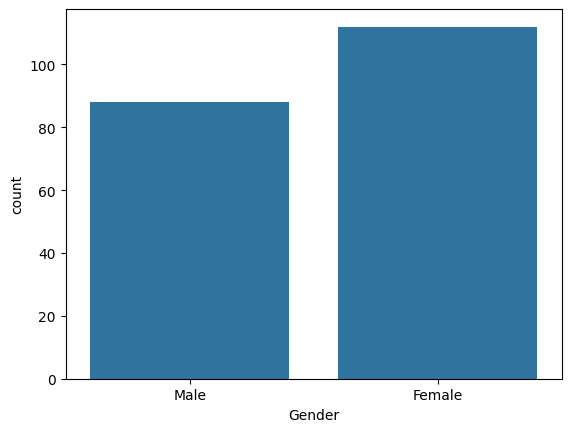

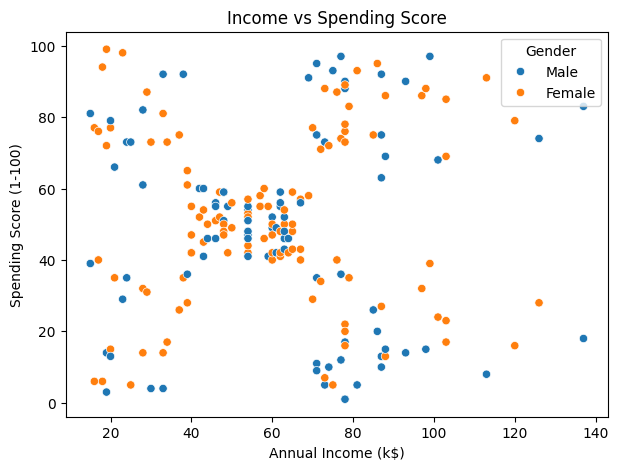

In [4]:
df.info()
df.describe()

# Check nulls
print(df.isnull().sum())

# Gender distribution
sns.countplot(x="Gender", data=df)
plt.show()

# Income vs Spending Score
plt.figure(figsize=(7,5))
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", hue="Gender", data=df)
plt.title("Income vs Spending Score")
plt.show()


In [5]:
# Encode Gender
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])  # Male=1, Female=0

# Features for clustering/classification
X = df.drop(["CustomerID"], axis=1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


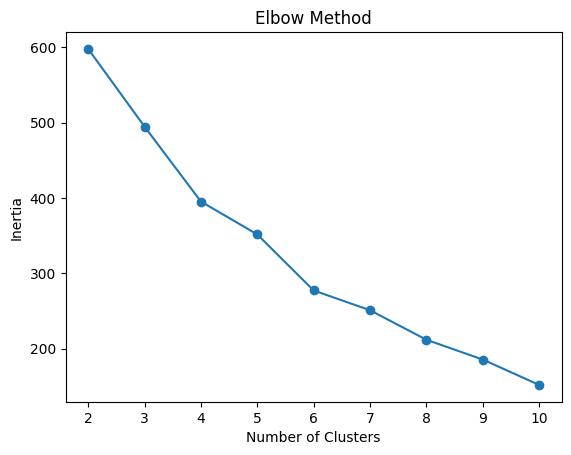

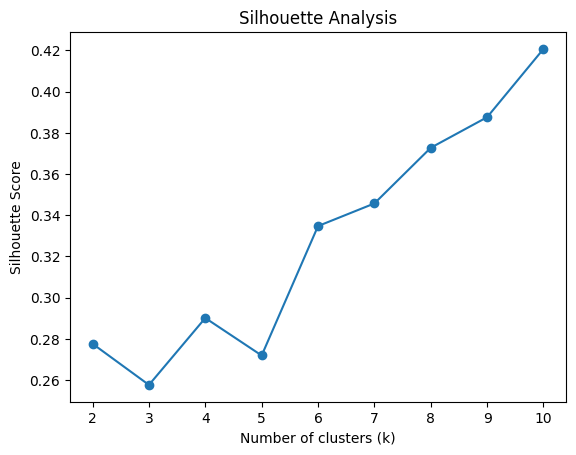

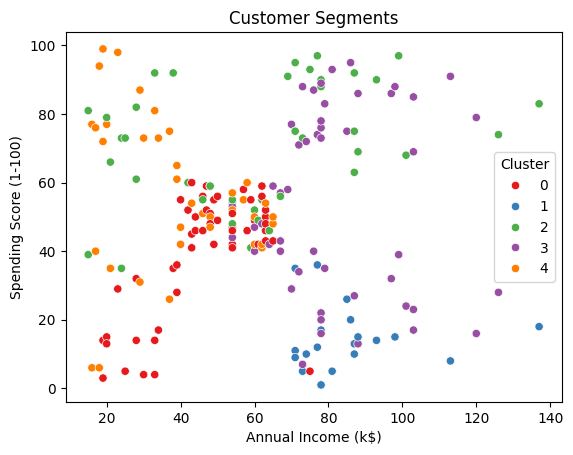

In [14]:
from sklearn.metrics import silhouette_score

# Elbow method
inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    labels = kmeans.fit_predict(X_scaled) 
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.plot(range(2,11), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

plt.plot(K, sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

# Fit KMeans with k=5 (common for this dataset)
kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", hue="Cluster", data=df, palette="Set1")
plt.title("Customer Segments")
plt.show()


               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        56.470588           46.098039               39.313725
1        39.500000           85.150000               14.050000
2        28.690476           60.904762               70.238095
3        37.897959           82.122449               54.448980
4        27.315789           38.842105               56.210526


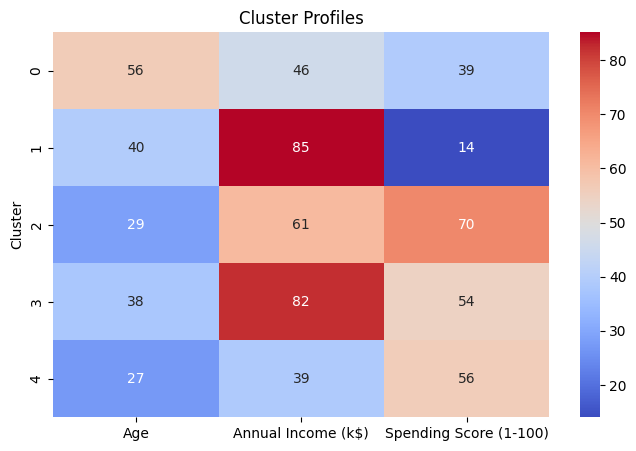

In [16]:
cluster_profile = df.groupby("Cluster")[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].mean()
print(cluster_profile)
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm")
plt.title("Cluster Profiles")
plt.show()

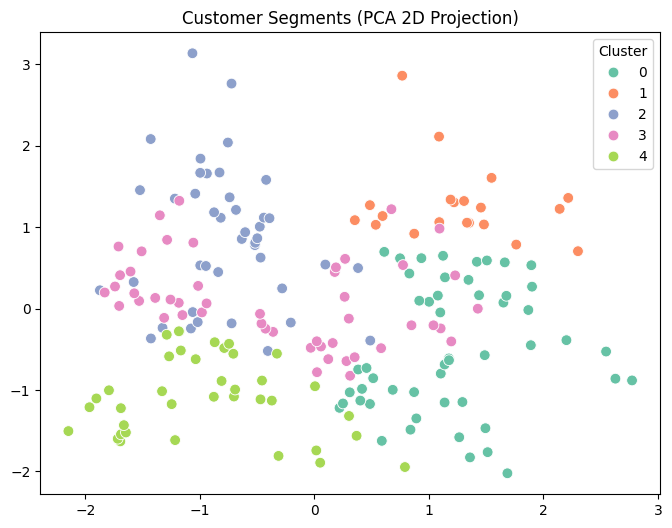

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["Cluster"], palette="Set2", s=60)
plt.title("Customer Segments (PCA 2D Projection)")
plt.show()


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df["Cluster"], test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    results.append([name, acc, prec, rec, f1])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
results_df


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.900,0.915556,0.900,0.901347
1,Random Forest,0.950,0.952778,0.950,0.950140
2,SVM,0.925,0.933333,0.925,0.925441


In [9]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

# ARI (requires true labels, here we fake by using predicted clusters as labels for comparison)
# Since dataset doesn't have ground-truth clusters, ARI isn't meaningful unless you compare to your supervised "Cluster" label
ari = adjusted_rand_score(df["Cluster"], kmeans.labels_)

# Silhouette Score (better for unsupervised validation)
silhouette = silhouette_score(X_scaled, kmeans.labels_)

print(f"KMeans Adjusted Rand Index: {ari:.4f}")
print(f"KMeans Silhouette Score: {silhouette:.4f}")


KMeans Adjusted Rand Index: 1.0000
KMeans Silhouette Score: 0.2719


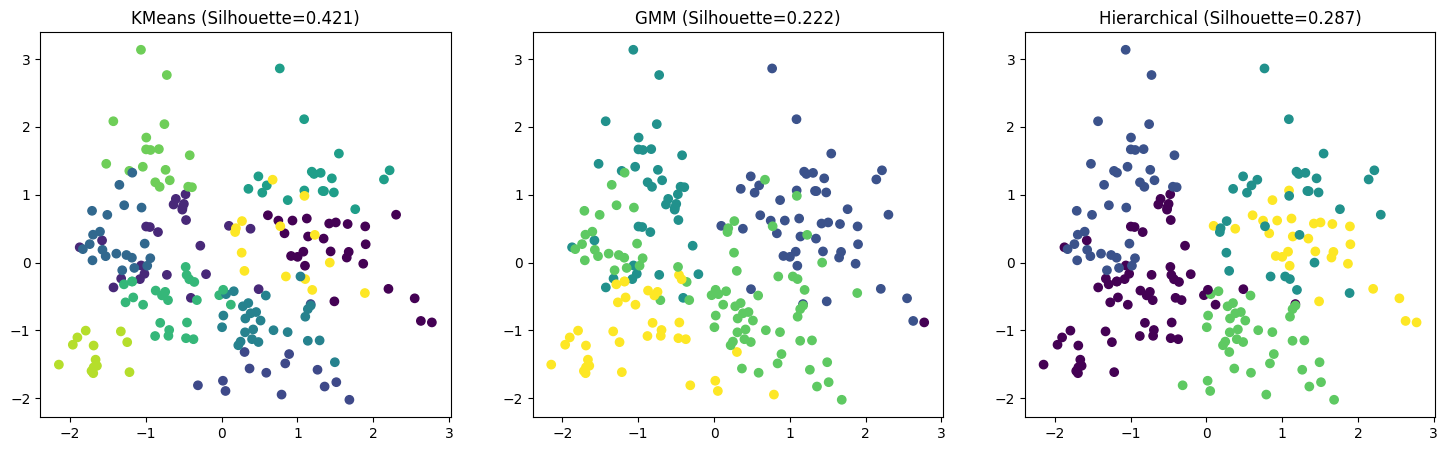

      Algorithm  Silhouette Score
0        KMeans          0.420764
1           GMM          0.221640
2  Hierarchical          0.286994


In [26]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# =============== GMM ===============
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
gmm_sil = silhouette_score(X_scaled, gmm_labels)

# =============== Hierarchical Clustering ===============
agg = AgglomerativeClustering(n_clusters=5)
agg_labels = agg.fit_predict(X_scaled)
agg_sil = silhouette_score(X_scaled, agg_labels)

# =============== PCA for Visualization ===============
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(pca_features[:,0], pca_features[:,1], c=labels, cmap="viridis")
axes[0].set_title(f"KMeans (Silhouette={sil:.3f})")

axes[1].scatter(pca_features[:,0], pca_features[:,1], c=gmm_labels, cmap="viridis")
axes[1].set_title(f"GMM (Silhouette={gmm_sil:.3f})")

axes[2].scatter(pca_features[:,0], pca_features[:,1], c=agg_labels, cmap="viridis")
axes[2].set_title(f"Hierarchical (Silhouette={agg_sil:.3f})")

plt.show()

# =============== Comparison Table ===============
import pandas as pd
results = pd.DataFrame({
    "Algorithm": ["KMeans", "GMM", "Hierarchical"],
    "Silhouette Score": [sil, gmm_sil, agg_sil]
})

print(results)